In [9]:
from rasterstats import zonal_stats
import geopandas as gpd

import os
import numpy as np
import matplotlib.pyplot as plt

from configs.config_object import ConfigObject

In [11]:
config = ConfigObject('../config.json')

In [ ]:
path_grid = config.paths.grid_folder_path #output

In [16]:
# to get the grid shape
with open(os.path.join(path_grid, f'x_epsg{config.epsg_projection}_grid.npy'), 'rb') as f:
    x = np.load(f)

# 1st method: interpolating measured bathymetry on grid

## Load bathymetry asc files

See at the end of the notebook if merging of different tiles is necessary

In [12]:
raw_bathy_path = config.paths.raw_bathy_path #input

## Load MITgcm grid

In [4]:
grid = gpd.read_file(os.path.join(path_grid, f"grid_epsg{config.epsg_projection}.gpkg"))

## Compute average depth per cell

In [6]:
# Compute zonal statistics
stats = zonal_stats(grid, raw_bathy_path, stats="mean", nodata=config.no_data_raw_bathy)

In [7]:
grid["avg_altitude"] = [s["mean"] for s in stats]

In [8]:
grid["avg_altitude"].max()

372.0291748046875

In [9]:
grid["avg_altitude"].min()

62.35941875

In [10]:
grid["avg_depth"] = grid["avg_altitude"] - config.lake_altitude

In [11]:
config.lake_altitude

372

In [12]:
grid["avg_altitude"].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: avg_altitude, dtype: float64

In [13]:
grid["avg_depth"] = grid["avg_depth"].fillna(2)
grid.loc[(grid["avg_depth"] > -0.5) & (grid["avg_depth"] < 0), "avg_depth"] = -0.5
depth_array = grid["avg_depth"].to_numpy().reshape(x.shape)

In [14]:
depth_array[42][43]

np.float64(-67.48815118488153)

In [15]:
depth_array[42][43] = -1

Text(0.5, 1.0, 'Depth (m)')

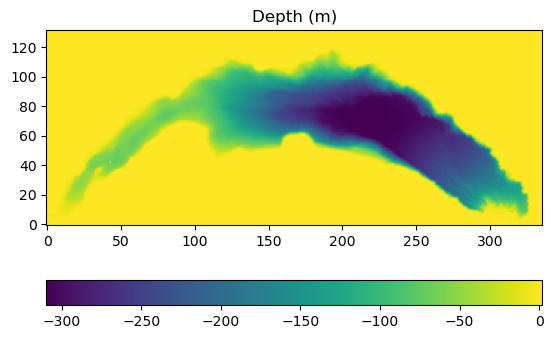

In [16]:
plt.imshow(depth_array)
plt.gca().invert_yaxis()
cbar = plt.colorbar(orientation="horizontal")
plt.title("Depth (m)")

# 2nd method: Loading bathymetry from gpkg file (in case it was modified in QGIS)

In [25]:
corrected_grid_name = f"grid_with_depth_epsg2056_with-Rhone"
grid = gpd.read_file(os.path.join(path_grid, f"{corrected_grid_name}.gpkg"))

In [26]:
depth_array = grid["avg_depth"].to_numpy().reshape(x.shape)

Text(0.5, 1.0, 'Depth (m)')

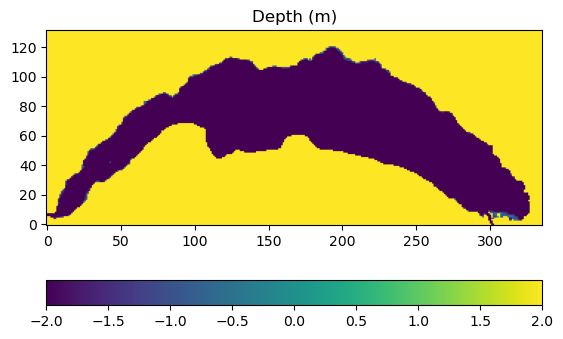

In [27]:
plt.imshow(depth_array, vmin=-2)
plt.gca().invert_yaxis()
cbar = plt.colorbar(orientation="horizontal")
plt.title("Depth (m)")

## Save bathymetry

In [28]:
# Write gpkg file
grid.to_file(os.path.join(config.paths.grid_folder_path, f"grid_with_depth_epsg{config.epsg_projection}.gpkg"), driver="GPKG")

In [29]:
# Write binary file
fid = open(os.path.join(config.paths.grid_folder_path, "bathy.bin"), 'wb')
depth_array.astype('>f8').tofile(fid)
fid.close()

# UTILS

#### Use to merge different tiles into one .tif file
import glob
import rasterio
from rasterio.merge import merge

#### Find all .asc files
asc_files = glob.glob("C:\Users\leroquan\Documents\Data\bathymetry\lucerne\swissbathy3d_vierwaldstaettersee_2056_5728.esriasciigrid\*.asc)

#### Open all the .asc files with rasterio
src_files_to_mosaic = []
for fp in asc_files:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

#### Merge them into a single mosaic
mosaic, out_trans = merge(src_files_to_mosaic)

#### Copy metadata from one of the source files and update
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "dtype": mosaic.dtype
})

#### Write the mosaic to disk
output_tif = os.path.join(raw_bathy_path, 'merged_output.tif')
with rasterio.open(output_tif, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"Merged {len(asc_files)} .asc files into {output_tif}")
